# «Культурист-датасаентист»

### Цель исследования

- Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    1) выделить целевые группы клиентов;  
    2) предложить меры по снижению оттока;  
    3) определить другие особенности взаимодействия с клиентами.

### Ход исследования
[Загрузка и обзор данных](#data-review)  
[Предобработка данных](#pre-processing)  
[Исследовательский анализ данных (EDA)](#analysis)  
[Модель прогонозирования оттока клиентов](#model)  
[Кластеризация клиентов](#cluster)  
[Выводы и рекомендации](#summary)

## Загрузка и обзор данных<a class="anchor" id="data-review"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pandas import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('---')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Предобработка данных<a class="anchor" id="pre-processing"></a>

### Поиск и обработка пропусков

In [4]:
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Пропуски не обнаружены.

### Поиск и обработка дубликатов

In [5]:
df.duplicated().sum()

0

Дубликаты не обнаружены.

### Переименование столбцов и изменение типов данных

In [6]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Создадим два списка: для бинарных признаков и для всех остальных.

In [7]:
bool_list = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
for b in bool_list:
    df[b] = df[b].astype('int8')

In [8]:
int_list = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

Изучим диапазон значений небинарных переменных для измения дипов данных:

In [9]:
print(df['contract_period'].unique())
print(df['month_to_end_contract'].unique())
print(df['lifetime'].unique())
print(df['age'].unique())

[ 6 12  1]
[ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
[ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
[29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]


In [10]:
df['contract_period'] = df['contract_period'].astype('int8')
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int8')
df['lifetime'] = df['lifetime'].astype('int8')
df['age'] = df['age'].astype('int16')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int8   
 1   near_location                      4000 non-null   int8   
 2   partner                            4000 non-null   int8   
 3   promo_friends                      4000 non-null   int8   
 4   phone                              4000 non-null   int8   
 5   contract_period                    4000 non-null   int8   
 6   group_visits                       4000 non-null   int8   
 7   age                                4000 non-null   int16  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int8   
 10  lifetime                           4000 non-null   int8   
 11  avg_class_frequency_total          4000 non-null   float

В ходе предобработки данных были проведены следующие операции:
- названия столбцов приведены к нижнему регистру;
- пропуски и дубликаты не обнаружены;
- изменены типы данных для оптимизации датафрейма.

## Исследовательский анализ данных (EDA)<a class="anchor" id="analysis"></a>

Посмотрим на статистику признаков нашего датасета:

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Также исследуем средние значения признаков ушедших и не ушедших клиентов:

In [13]:
df.groupby(by='churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Построим столбчатые диаграммы для бинарных признаков:

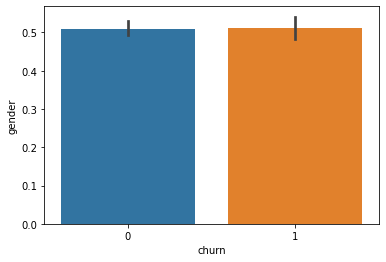

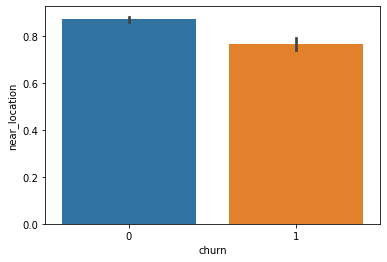

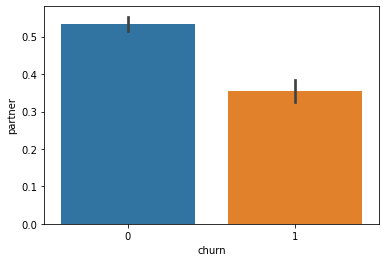

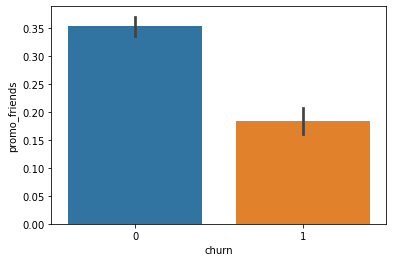

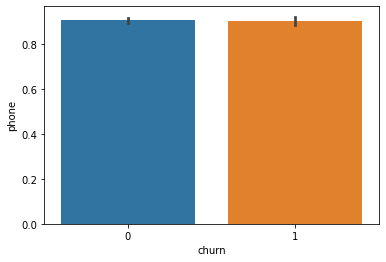

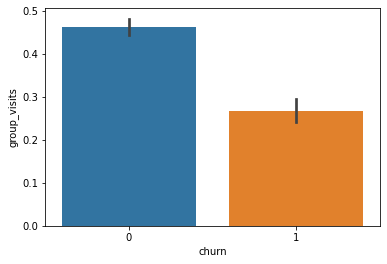

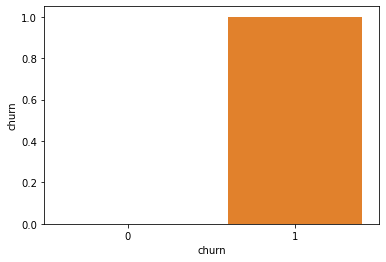

In [14]:
for i in bool_list:
    sns.barplot(data=df, x='churn', y=i)
    plt.show()

Из данных графиков видно что пользователи которые являются клиентами партнеров клуба, либо пришли по акции Приведи друга, либо посещают групповые занятия реже бросают тренировки.

Также построим гистограммы для небинарных признаков:

contract_period (churn: 0)


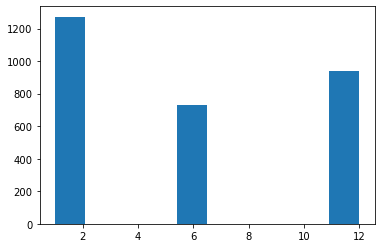

contract_period (churn: 1)


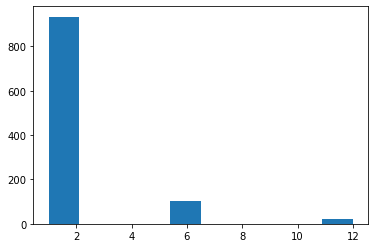

age (churn: 0)


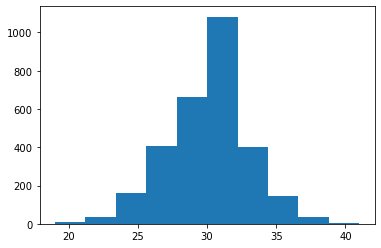

age (churn: 1)


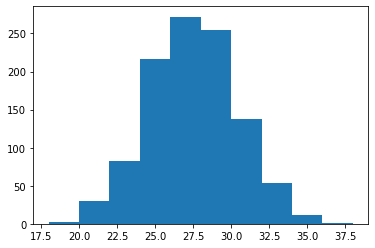

avg_additional_charges_total (churn: 0)


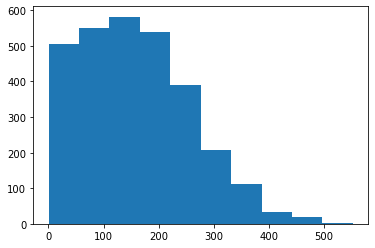

avg_additional_charges_total (churn: 1)


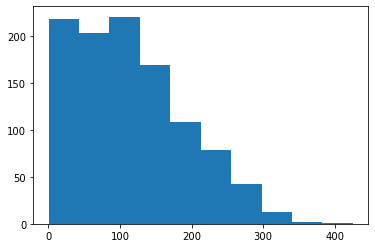

month_to_end_contract (churn: 0)


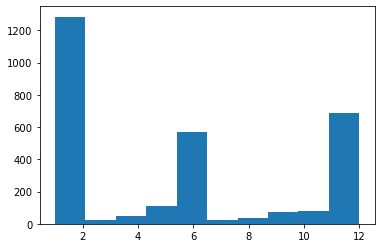

month_to_end_contract (churn: 1)


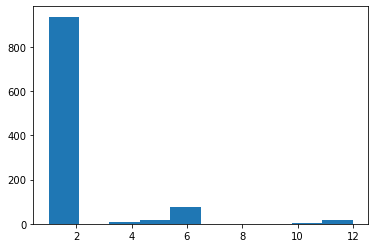

lifetime (churn: 0)


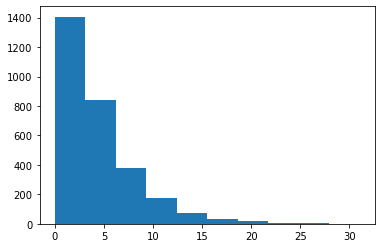

lifetime (churn: 1)


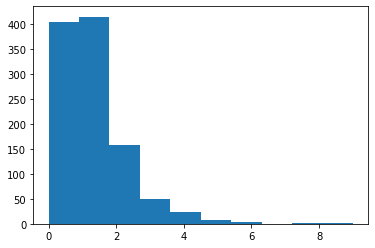

avg_class_frequency_total (churn: 0)


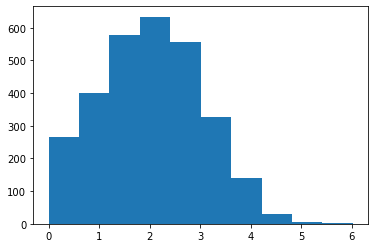

avg_class_frequency_total (churn: 1)


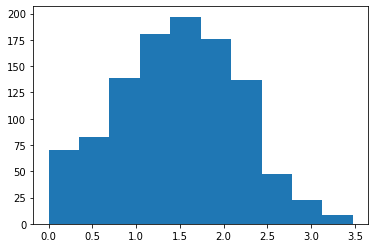

avg_class_frequency_current_month (churn: 0)


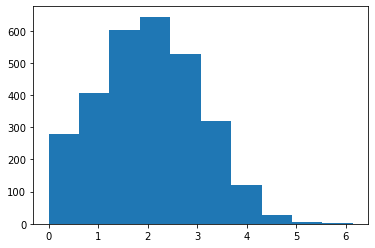

avg_class_frequency_current_month (churn: 1)


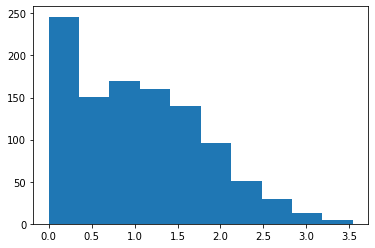

In [15]:
for i in int_list:
    for j in df['churn'].unique():
        print(f'{i} (churn: {j})')
        plt.hist(df[df['churn'] == j][i])
        plt.show()

Из данных графиков наиболее заметна разница в оттоке среди пользователей с краткосрочнми договорами и с малым количеством месяцев до конца договора.

Построим матрицу корреляций между признаками:

<AxesSubplot:>

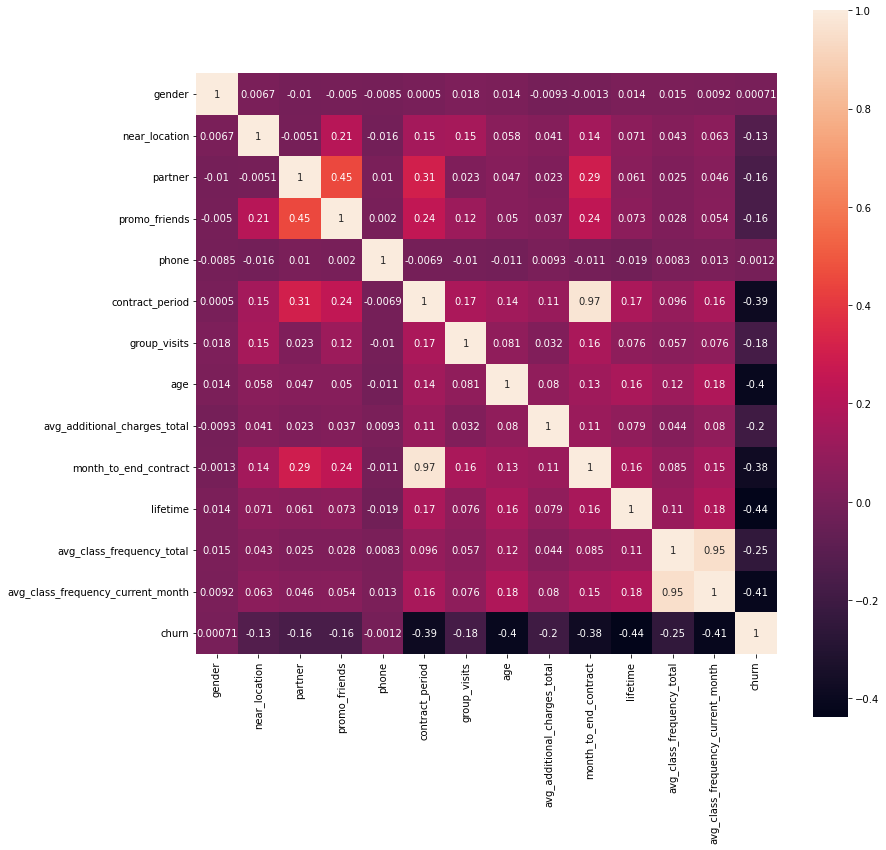

In [16]:
fig, ax = plt.subplots(figsize=(13,13)) 
cm = df.corr()
sns.heatmap(cm, annot=True, square=True)

Есть две пары сильно скореллированных признаков:
- общая частота посещения в неделю и частота посещения за последний месяц;
- длительность договора и количество месяцев до окончания договора.

Учитывая тот факт что признаки длительности договора взаимосвязаны почти на 100% можно смело избавиться от одного из признака.

## Модель прогнозирования оттока клиентов<a class="anchor" id="model"></a>

В данном случае временной фактор не играет роли в построении модели, поэтому разобъем данные на обучающую и валидационную выборки слуайным образом:

In [17]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель и сделаем прогноз с помощью логистической регресии:

In [19]:
lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:,1]

Обучим модель и сделаем прогноз с помощью случайного леса:

In [20]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = lr_model.predict_proba(X_test)[:,1]

In [21]:
print('Логистическая регресия:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_pred)))
print()
print('Случайный лес:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_pred)))

Логистическая регресия:
Accuracy: 0.93
Precision: 0.86
Recall: 0.83

Случайный лес:
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Алгоритм логистической регресии дает немного лучший результат по всем метрикам.

##  Кластеризация клиентов<a class="anchor" id="cluster"></a>

In [22]:
df_cluster = df.drop('churn', axis = 1)

In [23]:
sc = StandardScaler()
X_sc = sc.fit_transform(df_cluster)

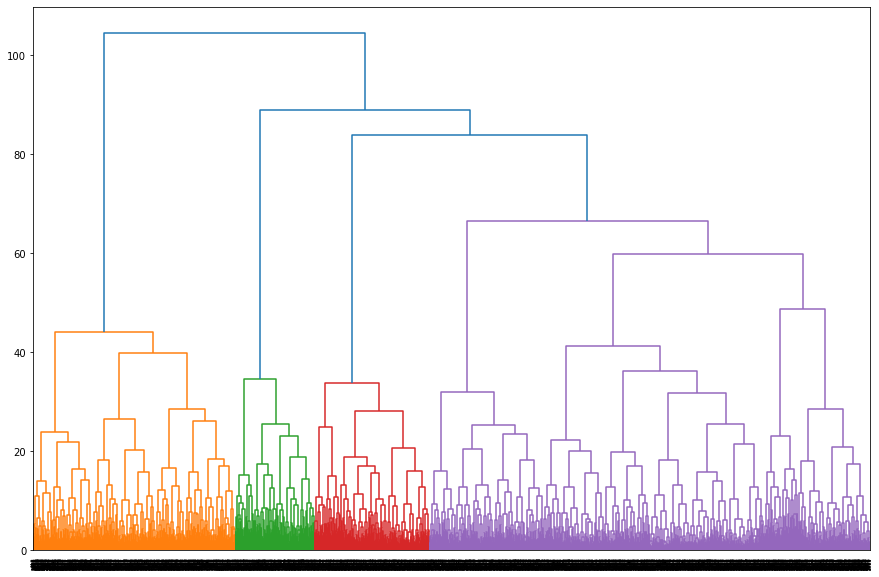

In [24]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Судя по дендрограмме выделяются четыре кластера. Однако, в соответствии с заданием заказчика выделим пять кластеров.

In [25]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
df['cluster_km'] = labels

In [26]:
df.pivot_table(df, index='cluster_km').T

cluster_km,0,1,2,3,4
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
avg_class_frequency_current_month,1.974789,1.716369,1.477324,1.012983,2.850161
avg_class_frequency_total,1.982055,1.847220,1.660461,1.247634,2.852002
churn,0.027723,0.267532,0.443564,0.514263,0.068019
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
gender,0.502970,0.522078,0.495050,0.485737,0.559666
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
lifetime,4.736634,3.924675,2.809901,2.440571,4.898568
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


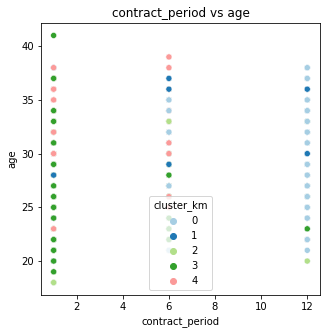

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


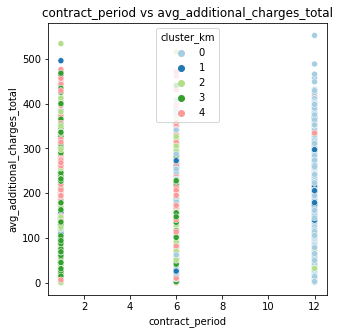

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


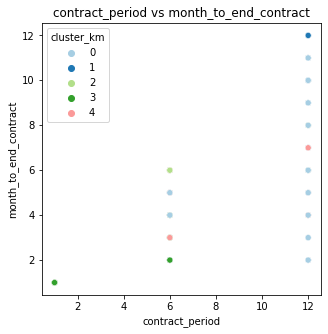

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


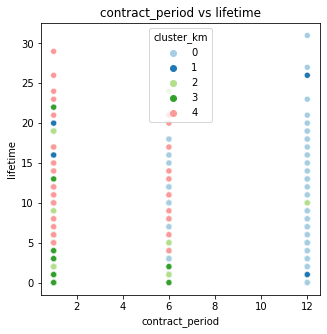

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


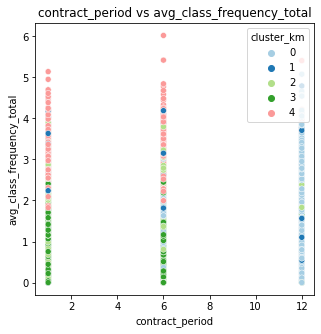

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


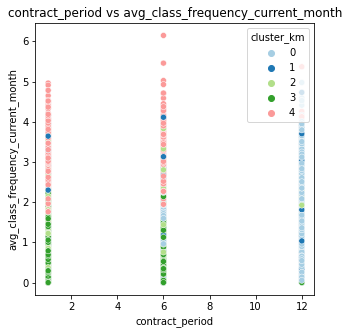

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


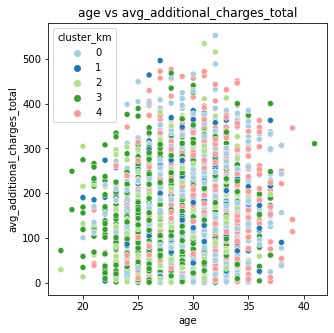

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


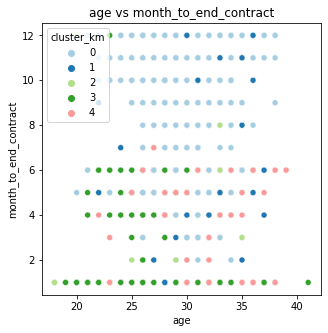

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


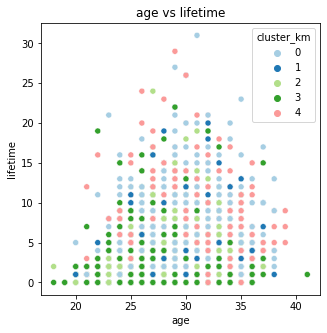

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


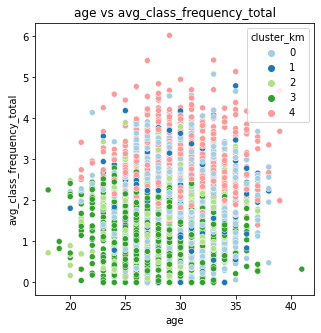

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


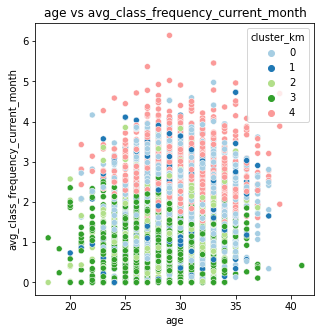

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


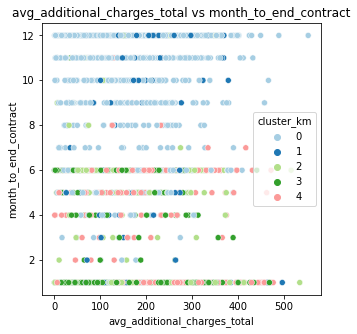

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


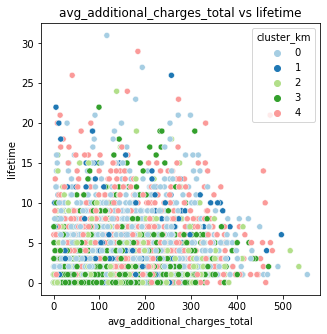

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


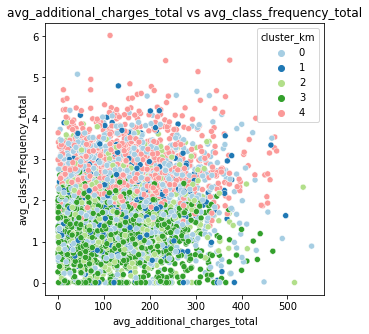

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


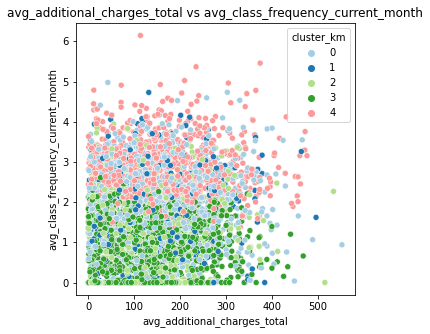

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


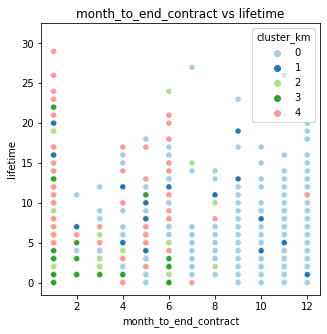

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


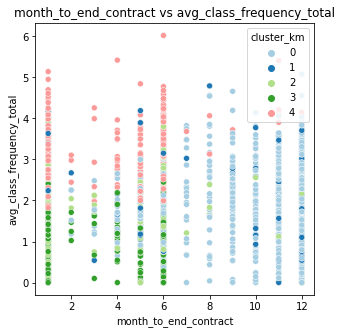

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


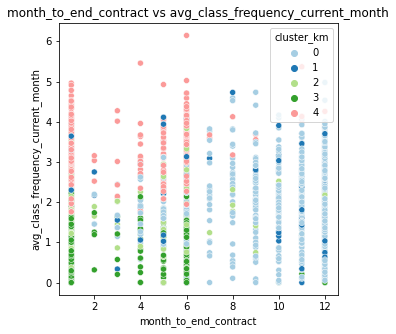

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


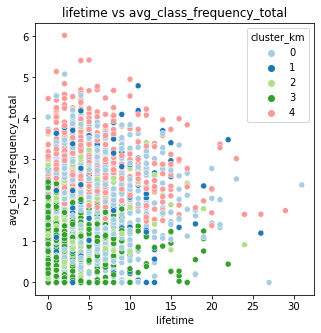

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


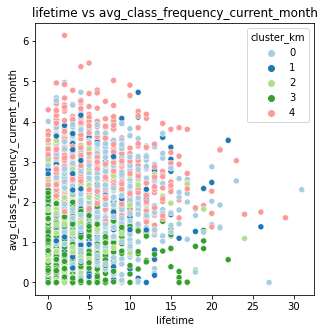

/Users/aksyutenko/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


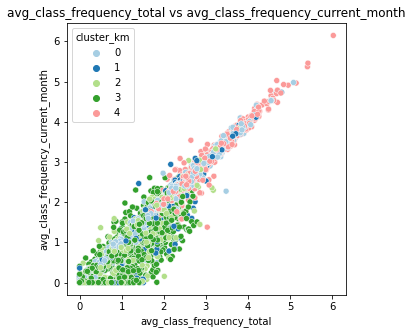

In [27]:
def show_clusters_on_plot(df, x, y, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x], df[y], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x, y))
    plt.show()

df_wo_cluster = df.drop('cluster_km', axis=1)

col_pairs = list(itertools.combinations(df_wo_cluster.drop(bool_list, axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster_km')

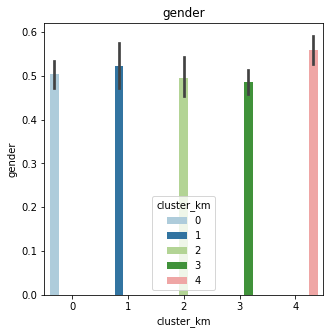

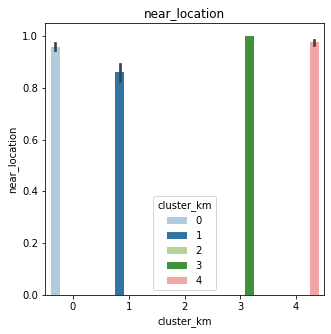

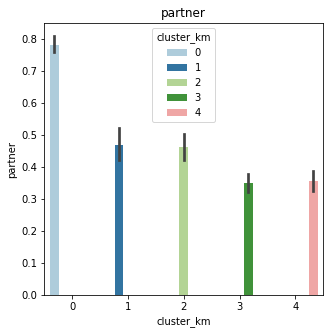

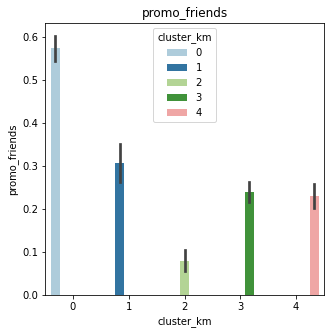

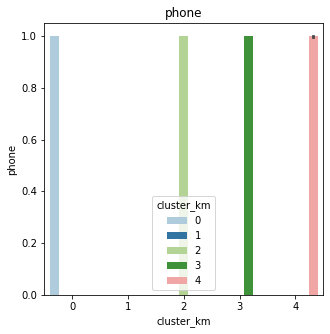

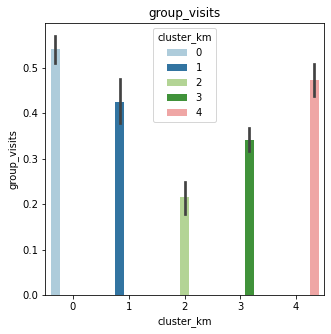

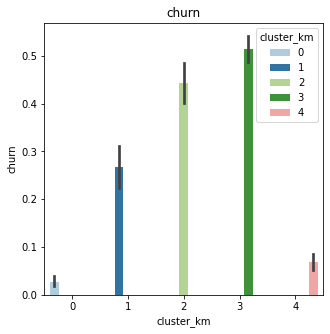

In [28]:
for i in bool_list:
    plt.figure(figsize=(5, 5))
    sns.barplot(data=df, x='cluster_km', y=i, hue=df['cluster_km'], palette='Paired')
    plt.title(i)
    plt.show()

Судя по средним пол и возраст не оказывают значительного влияния на вероятность ухода клиента и для всех кластеров находятся в одном диапазоне.  

Дополнительные расходы выше для клиентов с низкой вероятностью ухода, но это скорее следствие более частых посещений залов.

Среди тех для кого вероятность уйти выше (кластеры 2, 3, 4):
- не указавшие телефон со среднесрочным договором, средняя вероятность ухода;
- живущие далеко от залов, краткосрочный договор, высокая вероятность ухода;
- самый краткосрочный контракт и редкие посещения зала, высокая вероятность ухода;

## Вывод и рекомендации<a class="anchor" id="summary"></a>

По итогам анализа можно выделить кластеры:
1. Клиенты с долгосрочными контрактами, пришедшие по приглашению друзей или через партнерский контракт, высокая частота посещения зала, низкая вероятность ухода;
2. Не указавшие телефон, среднесрочный договор, средняя вероятность ухода;
3. Живущие далеко от залов, краткосрочный договор, высокая вероятность ухода;
4. Живущие рядом с залом, самый краткосрочный контракт и низкий лайфтайм, редкие посещения зала, самая высокая вероятность ухода;
5. Клиенты с самой высокой частотой посещения зала, самая низкая вероятность ухода.

Возможные меры для увеличения лайфтайма:
- Чаще всего уходят клиенты с маленьким лайфтаймом и краткосрочным договором, живущие рядом с залом. Скорее всего это те, кто решил попробовать зал именно из-за близости к дому. Таких клиентов можно заинтересовать скидкой на долгосрочный конракт или предложить попробовать групповые занятия (клиенты с высоким лайфтаймом часто посещают групповые занятия);
- Для клиентов живущих далеко от зала можно подобрать более удобную локацию;
- Для клиентов заключающих среднесрочные договоры можно предложить выгодные условия продления.

Наибольшим удеражнием обладают люди пришедшие по приглашению друзей или через партнерские контраты. Скорее всего данные предложения себя оправдывают, возможно расширение таких программ позволит удерживать больше клиентов.